In [26]:

from datetime import datetime

import numpy as np
import pandas as pd
from pycirclize import Circos



## Pre-process sources

In [27]:

def convert_date(x,date_format):
    """Different sources have different date formats stored as strings (DD/MM/YYYY, MM-DD-YYYY, etc...).
    This simple function converts them to a datetime single format.
    """
    try:
        return(datetime.strptime(x,date_format))
    except:
        return(np.nan)


In [3]:

def filter_rename_columns(df,col_list,new_col_list):
    """Simple function used to rename a dataframe columns based on a
    renaming list. Returns the same dataframe with only
    selected columns and rename them
    """
    rename_dict = dict()
    for i in range(len(col_list)):
        rename_dict[col_list[i]] =  new_col_list[i]

    df = df[col_list]
    df.rename(columns = rename_dict, inplace = True)

    return(df)


In [4]:

event_dict = {
    "Drought":"DR",
    "Flood":"FL",
    "Floods":"FL",
    "floods":"FL",
    "Flooding":"FL",
    "FF":"FL",
    "Pluvial/Flash Flood":"FL",
    "Epidemic":"EP",
    "Cholera":"EP",
    "Ebola":"EP",
    "Measles":"EP",
    "Earthquake":"EQ",
    "Earthquakes":"EQ",
    "Volcano":"VO",
    "Volcanic activity":"VO",
    "Volcanic Eruption":"VO",
    "Landslide":"LS",
    "landslide":"LS",
    "Mass Movement":"LS",
    "Mass movement (wet)":"LS",
    "Mass movement (dry)":"LS",
    "SL":"LS",
    "MS":"LS",
    "TC":"TC/ST",
    "ST":"TC/ST",
    "Cyclone":"TC/ST",
    "Cyclones":"TC/ST",
    "Typhoon":"TC/ST",
    "cyclone":"TC/ST",
    "Storm":"TC/ST",
    "Storm Surge":"TC/ST",
    "Fire":"WF",
    "Fires":"WF",
    "FR":"WF",
    "Wildfires":"WF",
    "Wildfire":"WF",
    "Forest fire":"WF",
    "HT":"HW/CW",
    "HW":"HW/CW",
    "CW":"HW/CW",
    "Heat Wave":"HW/CW",
    "Cold Wave":"HW/CW",
    "Extreme temperature":"HW/CW",
    "Extreme Temperature":"HW/CW",
    "Heat/Cold Wave":"HW/CW",
    "Population Movement":"Displacement",
    "Displacement/Migration":"Displacement",
}


### Source-specific loading and pre-processing

This should be improved / replaced by the work Evangelos has doing. Lots of hard-coding for now.

In [5]:
############## GDACS ##############


#Load all unique files (per year) into one single dataframe
input_gdacs_df = pd.DataFrame()
for file_year in range(2000,2025):
    filename = "../data/gdacs/gdacs_events_" + str(file_year) +".csv"
    new_df = pd.read_csv(filename)

    input_gdacs_df = pd.concat([input_gdacs_df, new_df])

#input column names
col_list = ["event_id","event_type","country_iso3","country_name","from_date","to_date"]
df = input_gdacs_df.copy()

#retrieve first country and first iso-code per event (should be improved in the future to account for all countries)
df["countries"] = df["countries"].fillna("")
df["country_name"] = df["countries"].apply(lambda x : x.split(",")[0].split("(")[0][:-1])
df["country_iso3"] = df["countries"].apply(lambda x : x.split(",")[0].split("(")[-1][:-1])
df = df[col_list]

#Format both initial and end date
df.rename(columns = {"event_id" : "gdacs_id"}, inplace = True)
df["from_date"] = df["from_date"].apply(lambda x : convert_date(x[:10],"%Y-%m-%d"))
df["to_date"] = df["to_date"].apply(lambda x : convert_date(x[:10],"%Y-%m-%d"))

#Rename event types following our custom taxonomy
for event in event_dict:
    df.loc[df["event_type"] == event, "event_type"] = event_dict[event]

df.drop_duplicates(inplace = True)
df.reset_index(drop = True, inplace = True)

gdacs_df = df.copy()

In [6]:
############## GLIDE ##############

#Load data
date_col = "event_date"
filename = "../data/glide/glide_events.csv"
input_glide_df = pd.read_csv(filename)

#Rename key columns
col_list = ["GLIDE_number","Event_Code","Country_Code","Country","Date_"]
new_col_list = ["glide_id","event_type","country_iso3","country_name",date_col]
df = filter_rename_columns(input_glide_df.copy(),col_list,new_col_list)

#Format event date
df[date_col] = df[date_col].apply(lambda x : convert_date(x,"%Y/%m/%d"))
df = df[~df[date_col].isna()].reset_index(drop = True)

#Rename event types following our custom taxonomy
for event in event_dict:
    df.loc[df["event_type"] == event, "event_type"] = event_dict[event]

glide_df = df.copy()

In [7]:
############## CERF ##############

#Load data
filename = "../data/cerf/cerf_emergency_data_dynamic_web_scrape.csv"
input_cerf_df = pd.read_csv(filename)
date_col = "approval_date"

#Rename key columns
col_list = ["project_code","emergency_type","country","approval_date"]
new_col_list = ["cerf_id","event_type","country_name",date_col]
df = filter_rename_columns(input_cerf_df.copy(),col_list,new_col_list)

#Format event date
df[date_col] = df[date_col].apply(lambda x : convert_date(x,"%d/%m/%Y"))
df = df[~df[date_col].isna()].reset_index(drop = True)

#Rename event types following our custom taxonomy
for event in event_dict:
    df.loc[df["event_type"] == event, "event_type"] = event_dict[event]

cerf_df = df.copy()


In [8]:
############## DISASTER CHART ##############

#Load data
filename = "../data/disaster-charter/charter_activations_web_scrape_2000_2025.csv"
input_charter_df = pd.read_csv(filename)
date_col = "date"

#Rename key columns
col_list = ["Activation ID","Type of Event","Location of Event","Date"]
new_col_list = ["charter_id","event_type","country_name",date_col]
df = filter_rename_columns(input_charter_df.copy(),col_list,new_col_list)

#Format event date
df[date_col] = df[date_col].apply(lambda x : convert_date(x,"%Y-%m-%d"))
df = df[~df[date_col].isna()].reset_index(drop = True)

#Rename event types following our custom taxonomy
for event in event_dict:
    df.loc[df["event_type"] == event, "event_type"] = event_dict[event]

# Not all events have an id. For now, we use the DataFrame id (column index)
# combined with the original id (column charter_id)
df.reset_index(inplace = True)
df["index"] = df["index"].apply(lambda x : "custom_" + str(x))
df["charter_id"] = df["charter_id"].astype("str")
df.loc[df["charter_id"] == "nan", "charter_id"] = df.loc[df["charter_id"] == "nan", "index"]
df.drop(columns = "index", inplace = True)

charter_df = df.copy()

In [9]:
############## EM-DAT ##############

#Load data
filename = "../data/emdat/public_emdat_custom_request_2025-06-04_c1e3334f-e027-4f8a-92d5-7ce401c7654c.xlsx"
input_emdat_df = pd.read_excel(filename)
date_col = "start_date"

#Filter events without a start day and create date column from year, month and day
df = input_emdat_df.copy()
df = df[~df["Start Day"].isna()]
df[date_col] = df.apply(lambda row : str(int(row["Start Year"])) + "/" + str(int(row["Start Month"])) + "/" + str(int(row["Start Day"])), axis = 1)

#Rename key columns
col_list = ["DisNo.","Disaster Type","ISO", "Country","start_date"]
new_col_list = ["emdat_id","event_type","country_iso3","country_name",date_col]
df = filter_rename_columns(df.copy(),col_list,new_col_list)

#Format event date
df[date_col] = df[date_col].apply(lambda x : convert_date(x,"%Y/%m/%d"))
df = df[~df[date_col].isna()].reset_index(drop = True)

#Rename event types following our custom taxonomy
for event in event_dict:
    df.loc[df["event_type"] == event, "event_type"] = event_dict[event]


emdat_df = df.copy()


In [10]:
############## IDMC ##############

#Load data
filename = "../data/idmc_idu/idus_all.json"
input_idmc_df = pd.read_json(filename)
date_col = "event_start_date"

df = input_idmc_df.copy()

#Rename key columns
col_list =  ["id","type","iso3","country","event_start_date"]
new_col_list = ["idmc_id","event_type","country_iso3","country_name",date_col]
df = filter_rename_columns(df.copy(),col_list,new_col_list)

#Format event date
df[date_col] = df[date_col].apply(lambda x : convert_date(x,"%Y-%m-%d"))
df = df[~df[date_col].isna()].reset_index(drop = True)

#Rename event types following our custom taxonomy
for event in event_dict:
    df.loc[df["event_type"] == event, "event_type"] = event_dict[event]

idmc_df = df.copy()


In [11]:
############## IFRC DREF ##############

#Load data
filename = "../data/ifrc_dref/IFRC_emergencies.csv"
input_dref_df = pd.read_csv(filename, on_bad_lines="skip")
date_col = "disaster_start_date"
df = input_dref_df.copy()

#Rename key columns
col_list =  ["id","dtype.name","countries.iso3","countries.name","disaster_start_date"]
new_col_list = ["dref_id","event_type","country_iso3","country_name",date_col]
df = filter_rename_columns(df.copy(),col_list,new_col_list)

#Format event date
df[date_col] = df[date_col].apply(lambda x : convert_date(x[:10],"%Y-%m-%d"))
df = df[~df[date_col].isna()].reset_index(drop = True)
df = df[df["disaster_start_date"].apply(lambda x : x.year > 1900)].reset_index(drop = True)
df["disaster_start_date"] = df["disaster_start_date"].astype("datetime64[ns]")

#Rename event types following our custom taxonomy
for event in event_dict:
    df.loc[df["event_type"] == event, "event_type"] = event_dict[event]

dref_df = df.copy()



## Match sources

In [12]:
def initialize_disaster_df(ref_df):
    """Create the reference dataframe based on the first source. GDACS is used as the first one
    but anyother could fill this role.
    """
    df = pd.DataFrame()

    disaster_col_list = ["event_type","country_iso3","country_name","from_date","to_date","gdacs_id"]
    df = ref_df[disaster_col_list].copy()

    df.rename(columns = {"from_date":"initial_date", "to_date":"end_date"}, inplace = True)
    df.reset_index(inplace = True)
    df.rename(columns = {"index" : "unique_id"}, inplace = True)

    return(df)


In [13]:
def initialize_new_source(source_name):
    """Define some key parameters depending on the source being added.
    These parameters are: 
    new_id => source unique id column name 
    match_col => columns used for the matching (besides event date)
    date_col => event date colum name
    delta_day_threshold => threshold for matching dates 
    """
    if source_name == "glide":
        new_id = "glide_id"
        match_col = ["event_type","country_iso3"]
        date_col = "event_date"
        delta_day_threshold = 7

    elif source_name == "cerf":
        new_id = "cerf_id"
        match_col = ["event_type","country_name"]
        date_col = "approval_date"
        delta_day_threshold = 14

    elif source_name == "charter":
        new_id = "charter_id"
        match_col = ["event_type","country_name"]
        date_col = "date"
        delta_day_threshold = 7

    elif source_name == "emdat":
        new_id = "emdat_id"
        match_col = ["event_type","country_iso3"]
        date_col = "start_date"
        delta_day_threshold = 7

    elif source_name == "idmc":
        new_id = "idmc_id"
        match_col = ["event_type","country_iso3"]
        date_col = "event_start_date"
        delta_day_threshold = 7

    elif source_name == "dref":
        new_id = "dref_id"
        match_col = ["event_type","country_iso3"]
        date_col = "disaster_start_date"
        delta_day_threshold = 7


    return new_id, match_col, date_col, delta_day_threshold


In [14]:
def add_new_source(disaster_df, new_source_df, source_name):
    """Match a new source to all the previous one added to the combined DataFrame.
    For now the matching is based on event date, type and country.
    """
    #Retrieve source parameters
    new_id, match_col, date_col, delta_day_threshold = initialize_new_source(source_name)

    #First match based on matching columns (event type and country by default)
    merge_df = disaster_df.merge(new_source_df, on = match_col, how = "inner", suffixes = ("","_new"))
    #Check if new event date is within the defined threshold in days to check if the dates match
    merge_df["date_match"] = ((merge_df[date_col] - merge_df["initial_date"]).apply(lambda x : x.days) >= - delta_day_threshold) & ((merge_df[date_col] - merge_df["end_date"]).apply(lambda x : x.days) <= delta_day_threshold)
    merge_df = merge_df[merge_df["date_match"]].reset_index(drop = True)
    #Update initial / end dates based on the new added event
    merge_df["initial_date"]  = merge_df[["initial_date",date_col]].min(axis=1)
    merge_df["end_date"]  = merge_df[["end_date",date_col]].max(axis=1)
    merge_df.drop(columns = ["country_name_new","country_iso3_new", date_col,"date_match"], inplace = True, errors="ignore")



    #Left outer dataframe contain events within the reference dataframe that are not present on the new source
    left_outer_df = disaster_df[~disaster_df["unique_id"].isin(list(merge_df["unique_id"].unique()))]
    #Right outer dataframe contain events within the new source that are not present on the reference dataframe
    new_source_df["initial_date"] = new_source_df[date_col]
    new_source_df["end_date"]  = new_source_df[date_col]
    new_source_df.drop(columns = [date_col], inplace = True)
    right_outer_df = new_source_df[~new_source_df[new_id].isin(list(merge_df[new_id].unique()))]

    #Combine events that are present both in the reference and new source (merge_df),
    #those who are only present on the reference (left_outer_df) and those only
    #present on the new source (right_outer_df).
    df = pd.concat([merge_df,left_outer_df,right_outer_df])
    df.drop(columns = "unique_id", inplace = True)
    df.reset_index(inplace = True)
    df.rename(columns = {"index" : "unique_id"}, inplace = True)

    return(df)



In [15]:
disaster_df = initialize_disaster_df(gdacs_df)
disaster_df = add_new_source(disaster_df, glide_df, "glide")
disaster_df = add_new_source(disaster_df, cerf_df, "cerf")
disaster_df = add_new_source(disaster_df, charter_df, "charter")
disaster_df = add_new_source(disaster_df, emdat_df, "emdat")
disaster_df = add_new_source(disaster_df, idmc_df, "idmc")
disaster_df = add_new_source(disaster_df, dref_df, "dref")


## Analysis

Analysis code is not well structured / commented. For now it was just a quick analysis but we could format it in the future
to make repetitive analysis easier

In [16]:
analysis_df = disaster_df.copy()

analysis_df["gdacs"] = analysis_df["gdacs_id"].notna()
analysis_df["glide"] = analysis_df["glide_id"].notna()
analysis_df["cerf"] = analysis_df["cerf_id"].notna()
analysis_df["charter"] = analysis_df["charter_id"].notna()
analysis_df["emdat"] = analysis_df["emdat_id"].notna()
analysis_df["idmc"] = analysis_df["idmc_id"].notna()
analysis_df["dref"] = analysis_df["dref_id"].notna()

analysis_df["nb_sources"] = analysis_df[["gdacs","glide","cerf","charter","emdat","idmc", "dref"]].sum(axis = 1)

Text(0.5, 1.0, 'Number of events per source')

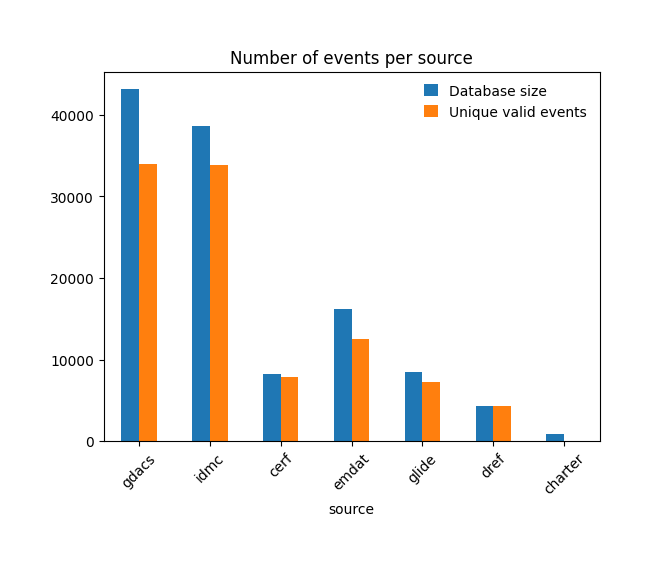

In [22]:
nb_events = []
valid_events = []

source_list = ["gdacs","idmc","cerf","emdat","glide", "dref","charter"]
source_df_dict = {
    "gdacs" : input_gdacs_df,
    "idmc" : input_idmc_df,
    "cerf" : input_cerf_df,
    "emdat" : input_emdat_df,
    "glide" : input_glide_df,
    "dref" : input_dref_df,
    "charter" : input_charter_df,
}

for source in source_list:
    col_id = source + "_id"
    nb_events.append(source_df_dict[source].shape[0])
    valid_events.append( len(analysis_df.loc[(analysis_df[col_id].notna()), col_id].unique()) )



count_df = pd.DataFrame()
count_df["source"] = source_list
count_df["Database size"] = nb_events
count_df["Unique valid events"] = valid_events

ax = count_df.plot.bar(x = "source", rot = 45)
ax.set_title("Number of events per source")

In [23]:
no_match_list = []
match_list = []

source_list = ["gdacs","idmc","cerf","emdat","glide", "dref","charter"]

for source in source_list:
    col_id = source + "_id"

    x = len(analysis_df.loc[(analysis_df[col_id].notna()) & (analysis_df["nb_sources"] == 1), col_id].unique())
    y = len(analysis_df.loc[(analysis_df[col_id].notna()) & (analysis_df["nb_sources"] > 1), col_id].unique())
    no_match_list.append(x)
    match_list.append(y)

plot_df = pd.DataFrame()
plot_df["source"] = source_list
plot_df["no_match"] = no_match_list
plot_df["match"] = match_list
plot_df["total"] = plot_df["no_match"] + plot_df["match"]
plot_df["score"] = plot_df["match"]/plot_df["total"]
plot_df["legend"] = plot_df.apply(lambda row : row["source"] + " - " + str(int(row["score"]*100)) + "%", axis = 1)

Text(0.5, 1.0, 'Matching events')

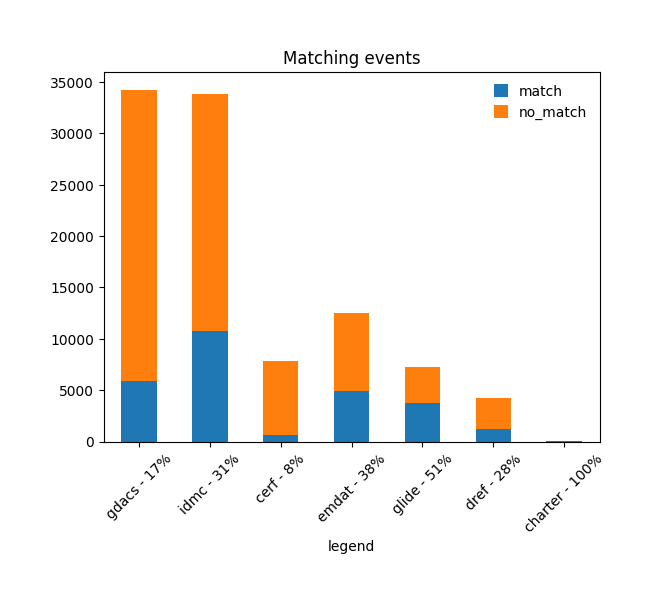

In [19]:


ax = plot_df[["legend","match","no_match"]].plot.bar(x = "legend", stacked=True, rot = 45)
ax.set_title("Matching events")

In [24]:
df = analysis_df.copy()
N = len(diag_source_list)

value_matrix = list()

for i in range(N):


    new_matrix = list()
    for j in range(N):

        col_i = diag_source_list[i].lower()
        col_j = diag_source_list[j].lower()
        if i == j or i > j:
            z = 0
        else:
            z = df[(df[col_i]) & (df[col_j])].shape[0]

        new_matrix.append(z)
    value_matrix.append(new_matrix)


         GDACS   IDMC  CERF  EMDAT  GLIDE  DREF  CHARTER
GDACS        0  22274  2862  17312  15842  9205     1622
IDMC         0      0   812  15900  13150  8179     1655
CERF         0      0     0   1749   2397  1432      136
EMDAT        0      0     0      0  15367  8558     1730
GLIDE        0      0     0      0      0  8072     1427
DREF         0      0     0      0      0     0     1025
CHARTER      0      0     0      0      0     0        0


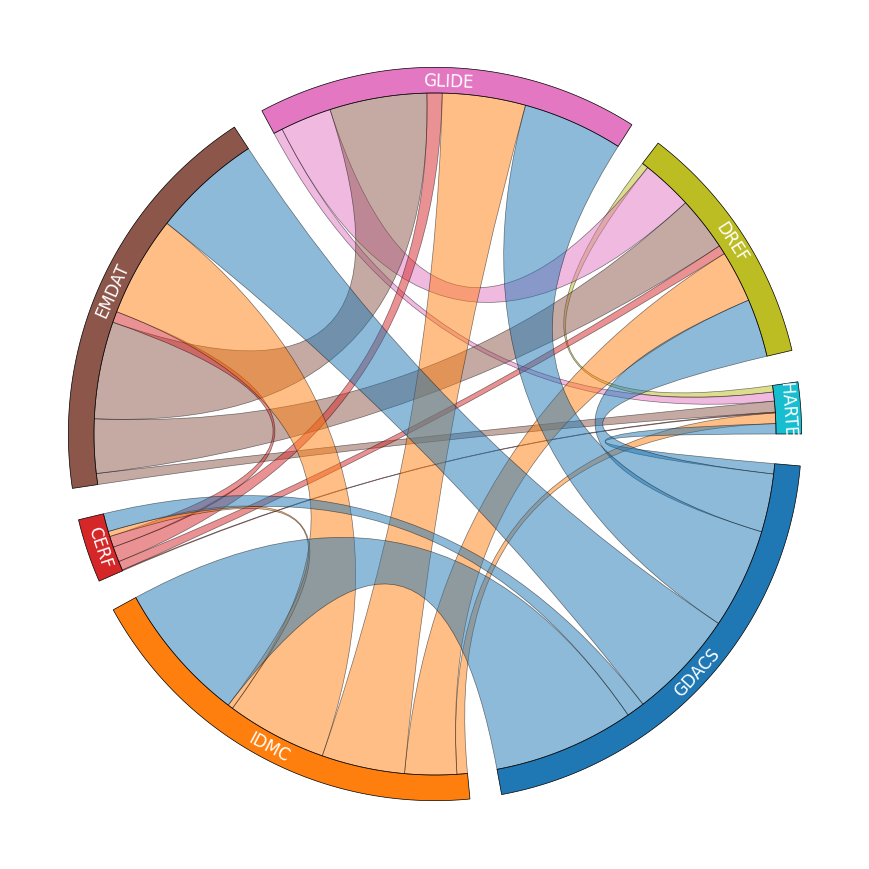

In [25]:
# Create matrix dataframe (3 x 6)

diag_source_list = ["GDACS", "IDMC", "CERF", "EMDAT", "GLIDE", "DREF", "CHARTER"]

row_names = diag_source_list
col_names = diag_source_list
matrix_data = value_matrix
matrix_df = pd.DataFrame(matrix_data, index=row_names, columns=col_names)

# Initialize from matrix (Can also directly load tsv matrix file)
circos = Circos.initialize_from_matrix(
    matrix_df,
    start=-265,
    end=95,
    space=5,
    r_lim=(93, 100),
    cmap="tab10",
    label_kws=dict(r=94, size=12, color="white"),
    link_kws=dict(ec="black", lw=0.5),
)

print(matrix_df)
fig = circos.plotfig()

